## Imports

In [183]:
# Standard library imports
import os
import random
import pickle

# Data analysis packages
import numpy as np
import pandas as pd
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from matplotlib import gridspec

# Image processing packages
import imageio
from PIL import Image, ImageSequence

# Braingeneers packages for analysis
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster


In [66]:
def generate_random_spike_data(width=16, length_ms=120000, average_rate=0.5, rate_std=0.1):
    """
    Generate spike times for neurons arranged in a width x width grid, with each neuron having a 
    potentially different firing rate determined by a normal distribution centered around 
    average_rate with a standard deviation of rate_std.
    
    Parameters:
    - width: The width of the square grid.
    - length_ms: The recording length in milliseconds.
    - average_rate: The average firing rate in Hz for the distribution.
    - rate_std: The standard deviation of the firing rates in Hz.
    
    Returns:
    A SpikeData object containing spike times and neuron positions.
    """
    np.random.seed(0)  # For reproducibility
    N_channels = width * width
    train = []

    # Generate spike times with variable firing rates
    for _ in range(N_channels):
        # Draw an average rate for this neuron from a normal distribution
        neuron_average_rate = np.random.normal(average_rate, rate_std)
        # Ensure the rate is not negative
        neuron_average_rate = max(neuron_average_rate, 0)
        # Calculate the number of spikes for this neuron
        num_spikes = np.random.poisson(neuron_average_rate * length_ms / 1000)
        # Generate spike times randomly within the recording length
        spike_times = np.random.uniform(0, length_ms, num_spikes)
        train.append(spike_times)

    # Generate positions for each neuron (channel) in a width x width grid
    positions = [(x, y) for x in range(width) for y in range(width)]

    # Initialize neuron_data with positions
    neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}

    # Assuming SpikeData is defined elsewhere and properly accepts these parameters
    spike_data = SpikeData(train, N=N_channels, length=length_ms, neuron_data=neuron_data)
    return spike_data

# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

def plot_raster(sd, title):
    idces, times = sd.idces_times()
    # Adjust the figsize parameter to change the figure size; (width, height) in inches
    fig, ax = plt.subplots(figsize=(10, 6))  # Example: 10 inches wide by 6 inches tall

    ax.scatter(times/1000, idces, marker='|', s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax.set_title(title)
    plt.show()

In [97]:
def firing_plotter(sd, global_min_rate, global_max_rate):
    # Custom colormap from pale red/pink to dark red/black
    colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
    cmap_name = "custom_red_black"
    n_bins = 100  # More bins will give us a finer gradient
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    firing_rates = calculate_mean_firing_rates(sd)
    neuron_x, neuron_y = [], []
    # Extract neuron positions
    for i, neuron in sd.neuron_data['positions'].items():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])

    plt.figure(figsize=(8, 6))
    # Plotting a small pale blue square at each neuron position
    plt.scatter(neuron_x, neuron_y, s=10, c='#add8e6', marker='s', alpha=0.6)
    scatter = plt.scatter(neuron_x, neuron_y, s=firing_rates*1.5, c=firing_rates, alpha=0.6, cmap=cm, vmin=global_min_rate, vmax=global_max_rate)

    # Creating dummy plots for the legend
    for rate in [20, 40, 60]:  # Example firing rates
        plt.scatter([], [], s=rate*1.5, c='gray', alpha=0.6, label=f'{rate} Hz')

    plt.title("Animation of Firing Rates for Random Data")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.colorbar(scatter, label='Firing Rate (Hz)')
    plt.gca().invert_yaxis()

    # Adding the legend for sizes with title
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Firing Rate', loc='upper right')

    # plt.show()

In [185]:
random_spike_data = generate_random_spike_data(width=16, length_ms=60000, average_rate=3.45, rate_std=0.9)

In [190]:
# Specify the filename where you want to store the object
filename = '/workspaces/human_hippocampus/dev/other/thomas/thesis/synthetic2/random_spike_data.pkl'

# Open a file in binary write mode and pickle the object
with open(filename, 'wb') as file:
    pickle.dump(random_spike_data, file)

print(f"The object has been pickled to {filename}")

The object has been pickled to /workspaces/human_hippocampus/dev/other/thomas/thesis/synthetic2/random_spike_data.pkl


In [181]:
def firing_plotter_with_raster(sd, global_min_rate, global_max_rate, time_windows):
    # Define your colors and colormap for the firing rate plots
    colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
    cmap_name = "custom_red_black"
    n_bins = 100
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
    
    # Window colors for the raster plot shading
    window_colors = ['#ffcccb', '#add8e6', '#77dd77', '#ffd700', '#fdbcb4']

    # Adjust figure size and GridSpec layout
    fig = plt.figure(figsize=(22, 10))
    gs = gridspec.GridSpec(2, 5, width_ratios=[1, 1, 1, 1, 0.05], height_ratios=[1, 0.8])
    fig.suptitle("Firing Rate by Time Window", fontsize=18)

    # Loop through time windows and plot firing rates
    for i, (start_time, end_time) in enumerate(time_windows):
        ax = plt.subplot(gs[0, i])
        current_sd = sd.subtime(start_time * 1000, end_time * 1000)  # Convert milliseconds to seconds
        firing_rates = calculate_mean_firing_rates(current_sd)  # Assuming this is a function you have
        neuron_x, neuron_y = [], []

        for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists
            neuron_x.append(neuron['position'][0])
            neuron_y.append(neuron['position'][1])

        scatter = ax.scatter(neuron_x, neuron_y, s=firing_rates*10, c=firing_rates, cmap=cm, vmin=global_min_rate, vmax=global_max_rate, alpha=0.6)

        # Update titles and labels to reflect seconds
        ax.set_title(f"{start_time}s to {end_time}s", fontsize=18)
        ax.set_xlabel("X Position", fontsize=14)
        ax.set_ylabel("Y Position", fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)

        ax.set_aspect('equal')
        ax.invert_yaxis()

    # Determine the overall min and max times for the raster plot, in seconds
    overall_min_time = min(start for start, _ in time_windows)
    overall_max_time = max(end for _, end in time_windows)

    # Add the raster plot beneath the subplots
    ax_raster = plt.subplot(gs[1, :-1])
    idces, times = sd.idces_times()  # Assuming this method exists within the sd object
    ax_raster.scatter(times/1000, idces, marker='|', s=1)
    ax_raster.set_xlabel("Time (seconds)", fontsize=14)
    ax_raster.set_ylabel('Unit #', fontsize=14)
    ax_raster.set_title("Raster Plot", fontsize=18)
    ax_raster.tick_params(axis='both', which='major', labelsize=12)

    ax_raster.set_xlim(overall_min_time, overall_max_time)

    # Shade each time window section on the raster plot with different colors
    for i, (start_time, end_time) in enumerate(time_windows):
        color = window_colors[i % len(window_colors)]
        ax_raster.axvspan(start_time, end_time, color=color, alpha=0.3)

    # Setup colorbar axis to match only the height of the firing rate plots
    cbar_ax = fig.add_subplot(gs[0, -1])
    cbar = fig.colorbar(scatter, cax=cbar_ax, label='Firing Rate (Hz)')
    cbar.set_label('Firing Rate (Hz)', size=14)
    cbar.ax.tick_params(labelsize=12)

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_8277/1162613377.py:29: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in current_sd.neuron_data['positions'].values():  # Assuming this structure exists


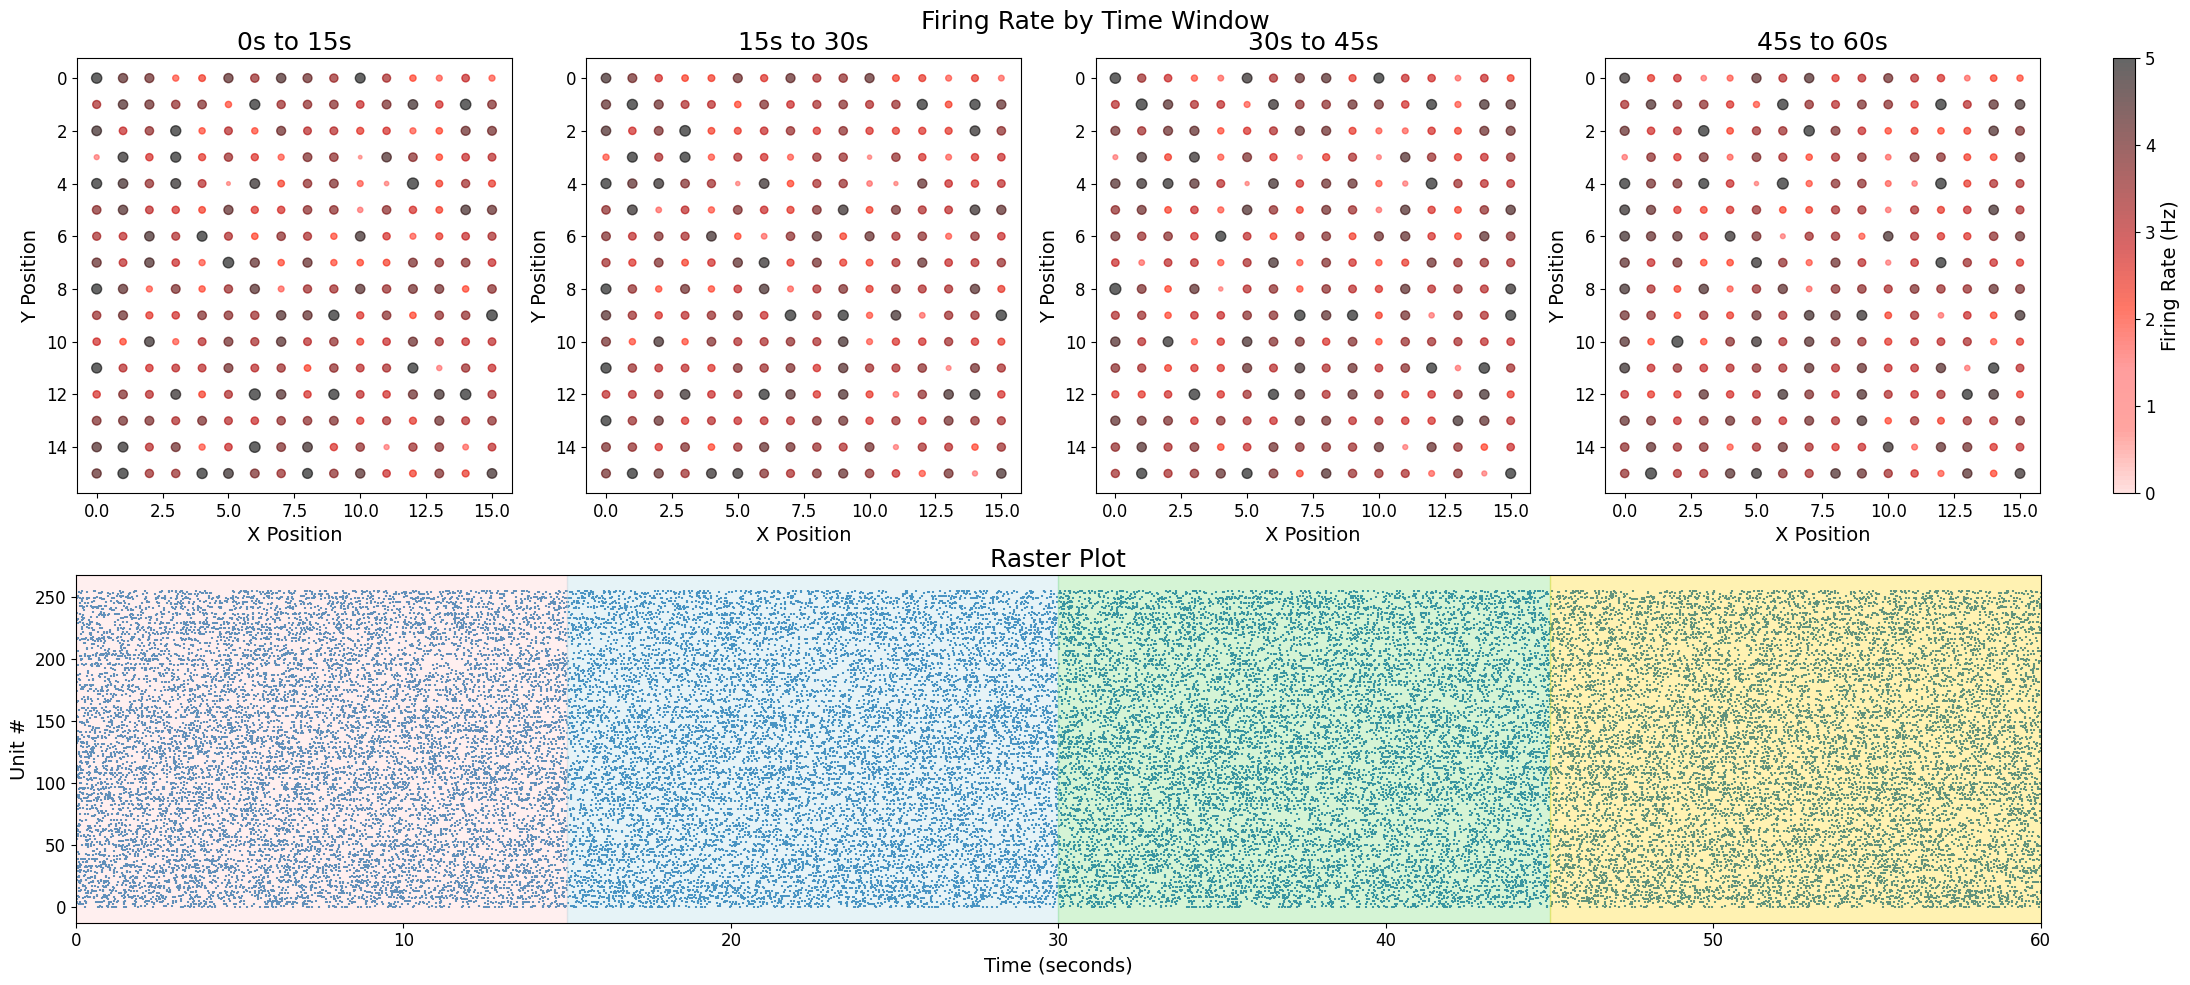

In [182]:
firing_plotter_with_raster(random_spike_data, 0, 5, [(0, 15), (15, 30), (30, 45), (45, 60)])